# Modeling và Prediction

## Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr  
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression

# Load data
weekly_full = pd.read_csv("Amazon_Weekly_Revenue.csv")

weekly_full.head(5)

,week,Revenue,Orders,Quantity,AvgDiscount,DeliveryRate,Category_Books,Category_Clothing,Category_Electronics,Category_Home & Kitchen,...,City_Charlotte,City_Chicago,City_Columbus,City_Dallas,City_Jacksonville,City_Los Angeles,City_Other,City_San Jose,City_Seattle,City_Washington
0,2019-12-30/2020-01-05,171833.3125,262,780,0.076527,0.740458,47,44,30,37,...,22,6,15,11,15,18,121,15,12,11
1,2020-01-06/2020-01-12,286423.7800,386,1149,0.073705,0.813472,66,65,56,72,...,23,13,18,22,29,18,178,21,22,19
2,2020-01-13/2020-01-19,291221.5500,410,1230,0.064878,0.748780,71,60,73,69,...,23,16,19,23,14,22,203,28,25,20
3,2020-01-20/2020-01-26,252467.7675,377,1155,0.072281,0.724138,54,62,78,57,...,13,16,19,22,19,16,181,15,18,32
4,2020-01-27/2020-02-02,281012.0725,387,1169,0.074806,0.767442,66,67,74,59,...,29,11,21,14,26,22,193,22,19,15


In [2]:
# 5. TAO SUMMARY TABLE VOI P-VALUE VA COEFFICIENT
correlation_cols = [col for col in weekly_full.columns if col != "week"]

# Tinh ma tran tuong quan
weekly_corr = weekly_full[correlation_cols].corr()

revenue_corr = weekly_corr["Revenue"].sort_values(ascending=False)
revenue_corr_filtered = revenue_corr.drop("Revenue")

def classify_correlation(corr_value):
    abs_corr = abs(corr_value)
    if abs_corr >= 0.7:
        return "Very Strong"
    elif abs_corr >= 0.5:
        return "Strong"
    elif abs_corr >= 0.3:
        return "Moderate"
    elif abs_corr >= 0.1:
        return "Weak"
    else:
        return "Very Weak"


# Tao DataFrame summary voi p-value va coefficient
summary_data = []
for var in revenue_corr_filtered.index:
    # Loai bo missing values
    valid_data = weekly_full[[var, "Revenue"]].dropna()

    if len(valid_data) > 2:
        # Tinh Pearson correlation va p-value
        corr_coef, p_value = pearsonr(valid_data[var], valid_data["Revenue"])

        # Tinh linear regression coefficient
        X = valid_data[[var]].values
        y = valid_data["Revenue"].values

        lr_model = LinearRegression()
        lr_model.fit(X, y)
        reg_coef = lr_model.coef_[0]
        intercept = lr_model.intercept_

        # Tinh R-squared
        r_squared = corr_coef**2

        # Danh gia significance
        if p_value < 0.001:
            significance = "***"
        elif p_value < 0.01:
            significance = "**"
        elif p_value < 0.05:
            significance = "*"
        else:
            significance = "NS"

        summary_data.append(
            {
                "Feature": var,
                "Correlation": corr_coef,
                "P_value": p_value,
                "Reg_Coefficient": reg_coef,
                "Intercept": intercept,
                "R_squared": r_squared,
                "Abs_Correlation": abs(corr_coef),
                "Direction": "Positive" if corr_coef > 0 else "Negative",
                "Strength": classify_correlation(corr_coef),
                "Significance": significance,
                "N_samples": len(valid_data),
            }
        )

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Abs_Correlation", ascending=False)
print("BANG TONG HOP CHI TIET (VOI P-VALUE & COEFFICIENT)")
print("--" * 30)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
print(summary_df.to_string(index=False))

BANG TONG HOP CHI TIET (VOI P-VALUE & COEFFICIENT)
------------------------------------------------------------
                       Feature  Correlation      P_value  Reg_Coefficient     Intercept  R_squared  Abs_Correlation Direction    Strength Significance  N_samples
                      Quantity     0.765536 1.604035e-51       215.923774  12922.002977   0.586045         0.765536  Positive Very Strong          ***        261
                        Orders     0.720732 4.170145e-43       701.025030  -7365.895438   0.519455         0.720732  Positive Very Strong          ***        261
         Country_United States     0.618772 5.670761e-29       734.832376  63981.293723   0.382879         0.618772  Positive      Strong          ***        261
                    City_Other     0.444182 4.793127e-14       643.938771 139422.954301   0.197297         0.444182  Positive    Moderate          ***        261
                      State_TX     0.433697 2.146891e-13       903.162896 1750

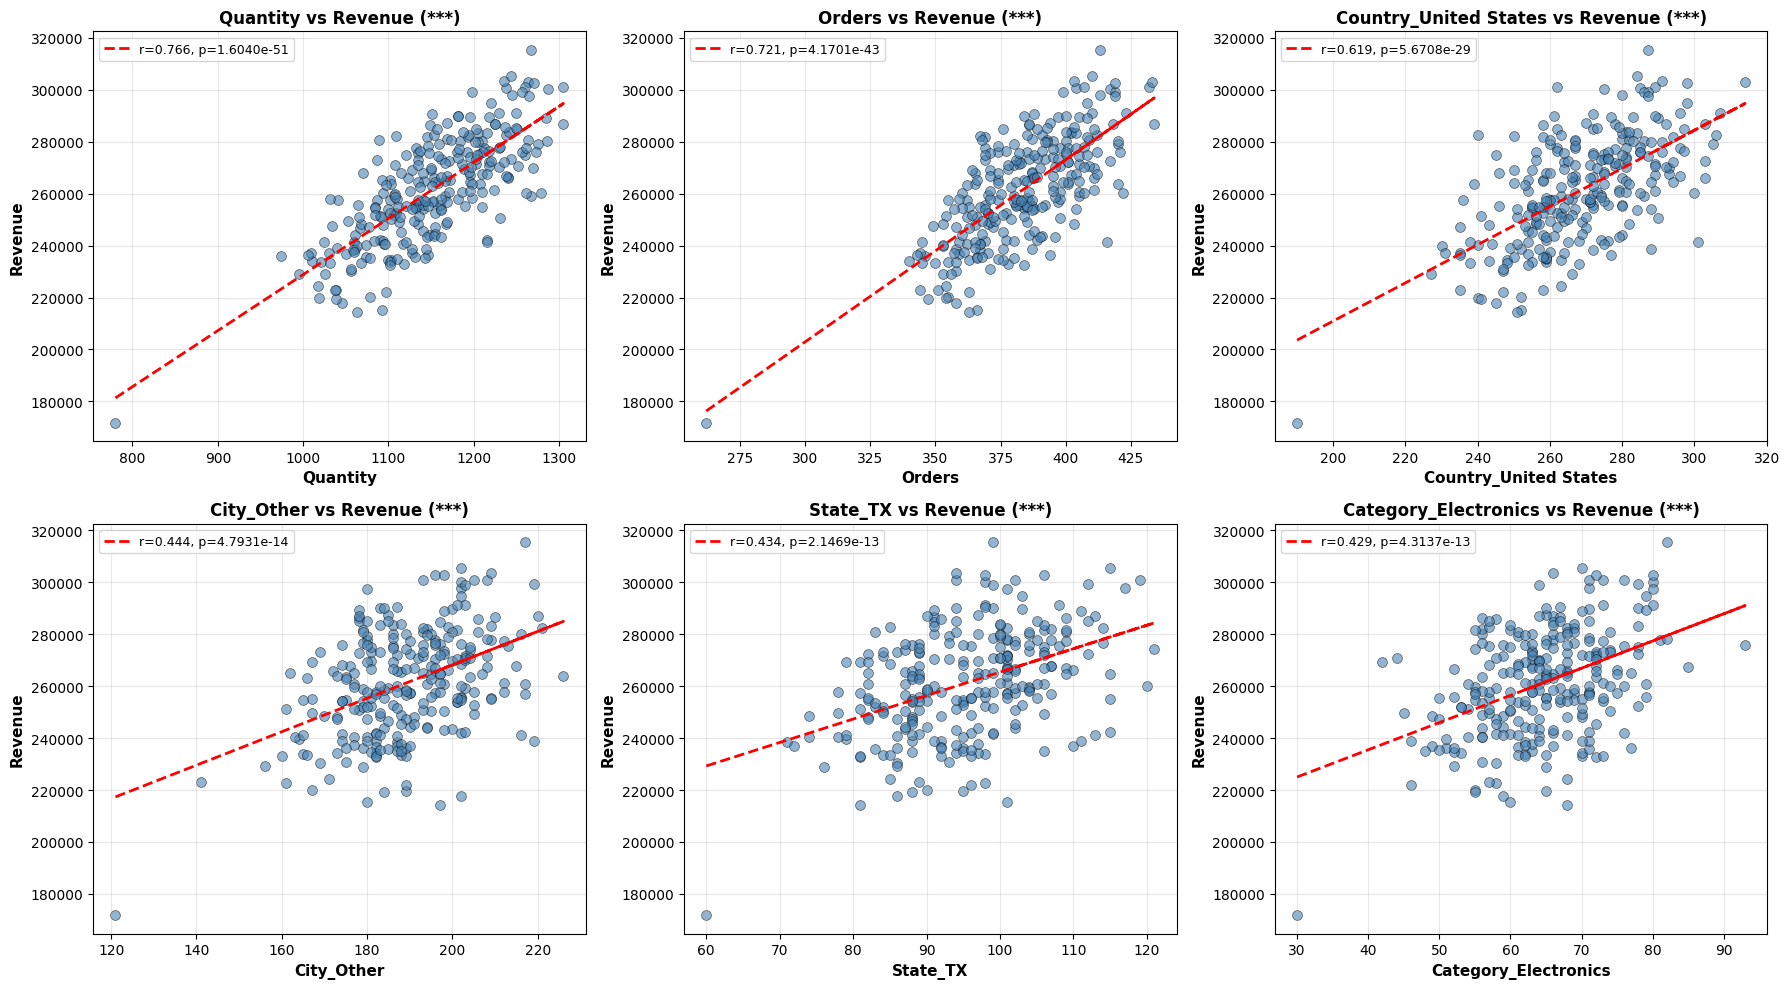

In [3]:
# 6. SCATTER PLOTS CHO 6 BIEN DAU TIEN CO Y NGHIA THONG KE (p < 0.05)
significant_vars_list = summary_df[summary_df["P_value"] < 0.05]["Feature"].tolist()[:6]

if len(significant_vars_list) > 0:
    n_vars = len(significant_vars_list)
    n_cols = 3
    n_rows = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    axes = axes.flatten()

    for idx, var in enumerate(significant_vars_list):
        # Lay du lieu hop le
        valid_data = weekly_full[[var, "Revenue"]].dropna()

        # Ve scatter plot
        axes[idx].scatter(
            valid_data[var],
            valid_data["Revenue"],
            alpha=0.6,
            s=50,
            color="steelblue",
            edgecolors="black",
            linewidth=0.5,
        )

        # Them regression line
        from scipy import stats

        slope, intercept, r_value, p_value, std_err = stats.linregress(
            valid_data[var], valid_data["Revenue"]
        )
        line = slope * valid_data[var] + intercept

        # Lay thong tin tu summary_df
        row_info = summary_df[summary_df["Feature"] == var].iloc[0]

        axes[idx].plot(
            valid_data[var],
            line,
            "r--",
            linewidth=2,
            label=f"r={row_info['Correlation']:.3f}, p={row_info['P_value']:.4e}",
        )

        axes[idx].set_xlabel(var, fontweight="bold", fontsize=11)
        axes[idx].set_ylabel("Revenue", fontweight="bold", fontsize=11)
        axes[idx].set_title(
            f"{var} vs Revenue ({row_info['Significance']})",
            fontweight="bold",
            fontsize=12,
        )
        axes[idx].legend(loc="best", fontsize=9)
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

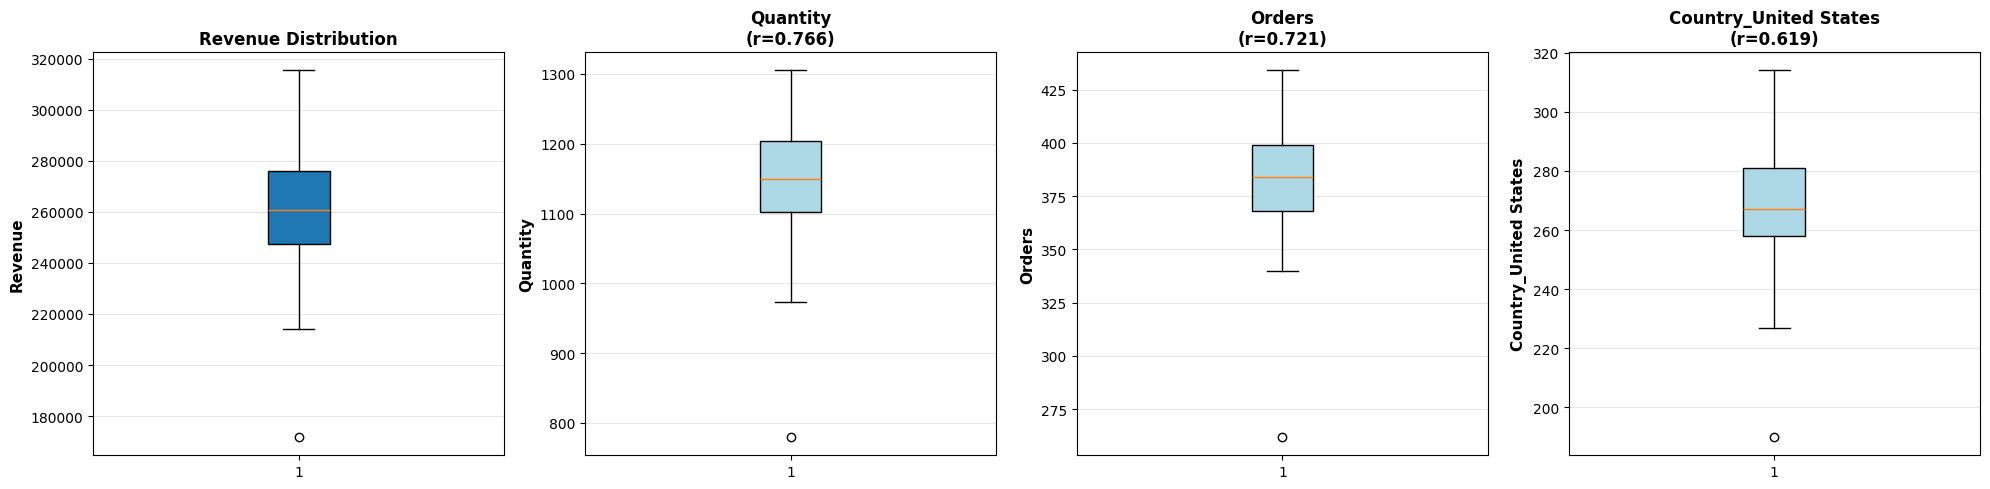

In [4]:
# 7. BOX PLOTS CHO CAC BIEN CO TUONG QUAN MANH (|r| >= 0.5)
strong_vars_list = summary_df[summary_df["Abs_Correlation"] >= 0.5]["Feature"].tolist()

if len(strong_vars_list) > 0:
    fig, axes = plt.subplots(
        1, len(strong_vars_list) + 1, figsize=(5 * (len(strong_vars_list) + 1), 5)
    )

    if len(strong_vars_list) == 0:
        axes = [axes]

    # Box plot cho Revenue
    axes[0].boxplot(weekly_full["Revenue"].dropna(), vert=True, patch_artist=True)
    axes[0].set_ylabel("Revenue", fontweight="bold", fontsize=11)
    axes[0].set_title("Revenue Distribution", fontweight="bold", fontsize=12)
    axes[0].grid(True, alpha=0.3, axis="y")

    # Box plots cho cac bien tuong quan manh
    for idx, var in enumerate(strong_vars_list, 1):
        bp = axes[idx].boxplot(weekly_full[var].dropna(), vert=True, patch_artist=True)
        bp["boxes"][0].set_facecolor("lightblue")

        axes[idx].set_ylabel(var, fontweight="bold", fontsize=11)

        row_info = summary_df[summary_df["Feature"] == var].iloc[0]
        axes[idx].set_title(
            f"{var}\n(r={row_info['Correlation']:.3f})",
            fontweight="bold",
            fontsize=12,
        )
        axes[idx].grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.plotting import autocorrelation_plot

print("=" * 80)
print("LINEAR REGRESSION ASSUMPTIONS TESTING")
print("=" * 80)

# Prepare data
all_features = [col for col in weekly_full.columns if col not in ["week", "Revenue"]]
X = weekly_full[all_features].copy()
y = weekly_full["Revenue"].copy()

# Remove constant columns
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
if constant_cols:
    X = X.drop(columns=constant_cols)
    all_features = [col for col in all_features if col not in constant_cols]

print(f"\nDataset: {X.shape[0]} samples, {X.shape[1]} features")

# Fit model
X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y, X_with_const).fit()
y_pred = model_sm.predict(X_with_const)
residuals = y - y_pred

print(f"R-squared: {model_sm.rsquared:.4f}")
print(f"Adjusted R-squared: {model_sm.rsquared_adj:.4f}")

# ============================================================================
# ASSUMPTION 1: LINEARITY
# ============================================================================
print("1. LINEARITY TEST (Spearman vs Pearson)")

from scipy.stats import pearsonr, spearmanr

linearity_results = []
for feature in all_features:
    pearson_r, _ = pearsonr(X[feature], y)
    spearman_r, _ = spearmanr(X[feature], y)
    diff = abs(spearman_r - pearson_r)
    linearity_results.append(
        {"Feature": feature, "Pearson_r": pearson_r, "Spearman_r": spearman_r, "Difference": diff}
    )

linearity_df = pd.DataFrame(linearity_results).sort_values("Difference", ascending=False)
non_linear_count = (linearity_df["Difference"] >= 0.1).sum()

print(f"- Non-linear features: {non_linear_count}/{len(all_features)}")
print(f"- Result: {'PASS' if non_linear_count <= len(all_features) * 0.3 else 'FAIL'}")

# ============================================================================
# ASSUMPTION 2: NORMALITY OF RESIDUALS
# ============================================================================
print("2. NORMALITY OF RESIDUALS")

shapiro_stat, shapiro_p = stats.shapiro(residuals)
jb_stat, jb_p = stats.jarque_bera(residuals)

print(f"- Shapiro-Wilk p-value: {shapiro_p:.4e} ({'PASS' if shapiro_p > 0.05 else 'FAIL'})")
print(f"- Jarque-Bera p-value: {jb_p:.4e} ({'PASS' if jb_p > 0.05 else 'FAIL'})")

normality_pass = shapiro_p > 0.05 and jb_p > 0.05
print(f"- Result: {'PASS' if normality_pass else 'FAIL'}")

# ============================================================================
# ASSUMPTION 3: HOMOSCEDASTICITY
# ============================================================================

print("3. HOMOSCEDASTICITY")

bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_with_const)
white_stat, white_p, _, _ = het_white(residuals, X_with_const)

print(f"- Breusch-Pagan p-value: {bp_p:.4e} ({'PASS' if bp_p > 0.05 else 'FAIL'})")
print(f"- White p-value: {white_p:.4e} ({'PASS' if white_p > 0.05 else 'FAIL'})")

homoscedasticity_pass = bp_p > 0.05 and white_p > 0.05
print(f"- Result: {'PASS' if homoscedasticity_pass else 'FAIL'}")

# ============================================================================
# ASSUMPTION 4: NO AUTOCORRELATION
# ============================================================================
print("4. NO AUTOCORRELATION")


dw_stat = durbin_watson(residuals)
autocorr_pass = 1.5 <= dw_stat <= 2.5

print(f"- Durbin-Watson: {dw_stat:.4f}")
print(f"- Result: {'PASS' if autocorr_pass else 'FAIL'} (acceptable range: 1.5-2.5)")

# ============================================================================
# ASSUMPTION 5: NO MULTICOLLINEARITY
# ============================================================================
print("5. NO MULTICOLLINEARITY (VIF)")


vif_data = pd.DataFrame()
vif_data["Feature"] = all_features
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(all_features))]
vif_data = vif_data.sort_values("VIF", ascending=False)

high_vif_count = (vif_data["VIF"] > 10).sum()
inf_vif_count = (vif_data["VIF"] == np.inf).sum()

print(f"- Features with VIF > 10: {high_vif_count}")
print(f"- Features with VIF = inf: {inf_vif_count}")
print(f"- Result: {'PASS' if high_vif_count == 0 else 'FAIL'}")

multicollinearity_pass = high_vif_count == 0

# ============================================================================
# SUMMARY
# ============================================================================

print("SUMMARY")

assumptions = {
    "Linearity": "PASS" if non_linear_count <= len(all_features) * 0.3 else "FAIL",
    "Normality": "PASS" if normality_pass else "FAIL",
    "Homoscedasticity": "PASS" if homoscedasticity_pass else "FAIL",
    "No Autocorrelation": "PASS" if autocorr_pass else "FAIL",
    "No Multicollinearity": "PASS" if multicollinearity_pass else "FAIL",
}

for assumption, result in assumptions.items():
    print(f"{assumption}: {result}")

passed_count = sum([1 for v in assumptions.values() if "PASS" in v])
print(f"\nOverall: {passed_count}/5 assumptions passed")

LINEAR REGRESSION ASSUMPTIONS TESTING

Dataset: 261 samples, 48 features
R-squared: 0.7960
Adjusted R-squared: 0.7600
1. LINEARITY TEST (Spearman vs Pearson)
- Non-linear features: 0/48
- Result: PASS
2. NORMALITY OF RESIDUALS
- Shapiro-Wilk p-value: 6.1824e-01 (PASS)
- Jarque-Bera p-value: 8.1422e-01 (PASS)
- Result: PASS
3. HOMOSCEDASTICITY
- Breusch-Pagan p-value: 8.2292e-01 (PASS)
- White p-value: 4.7089e-01 (PASS)
- Result: PASS
4. NO AUTOCORRELATION
- Durbin-Watson: 2.1635
- Result: PASS (acceptable range: 1.5-2.5)
5. NO MULTICOLLINEARITY (VIF)


/home/khoa/miniconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


- Features with VIF > 10: 48
- Features with VIF = inf: 45
- Result: FAIL
SUMMARY
Linearity: PASS
Normality: PASS
Homoscedasticity: PASS
No Autocorrelation: PASS
No Multicollinearity: FAIL

Overall: 4/5 assumptions passed


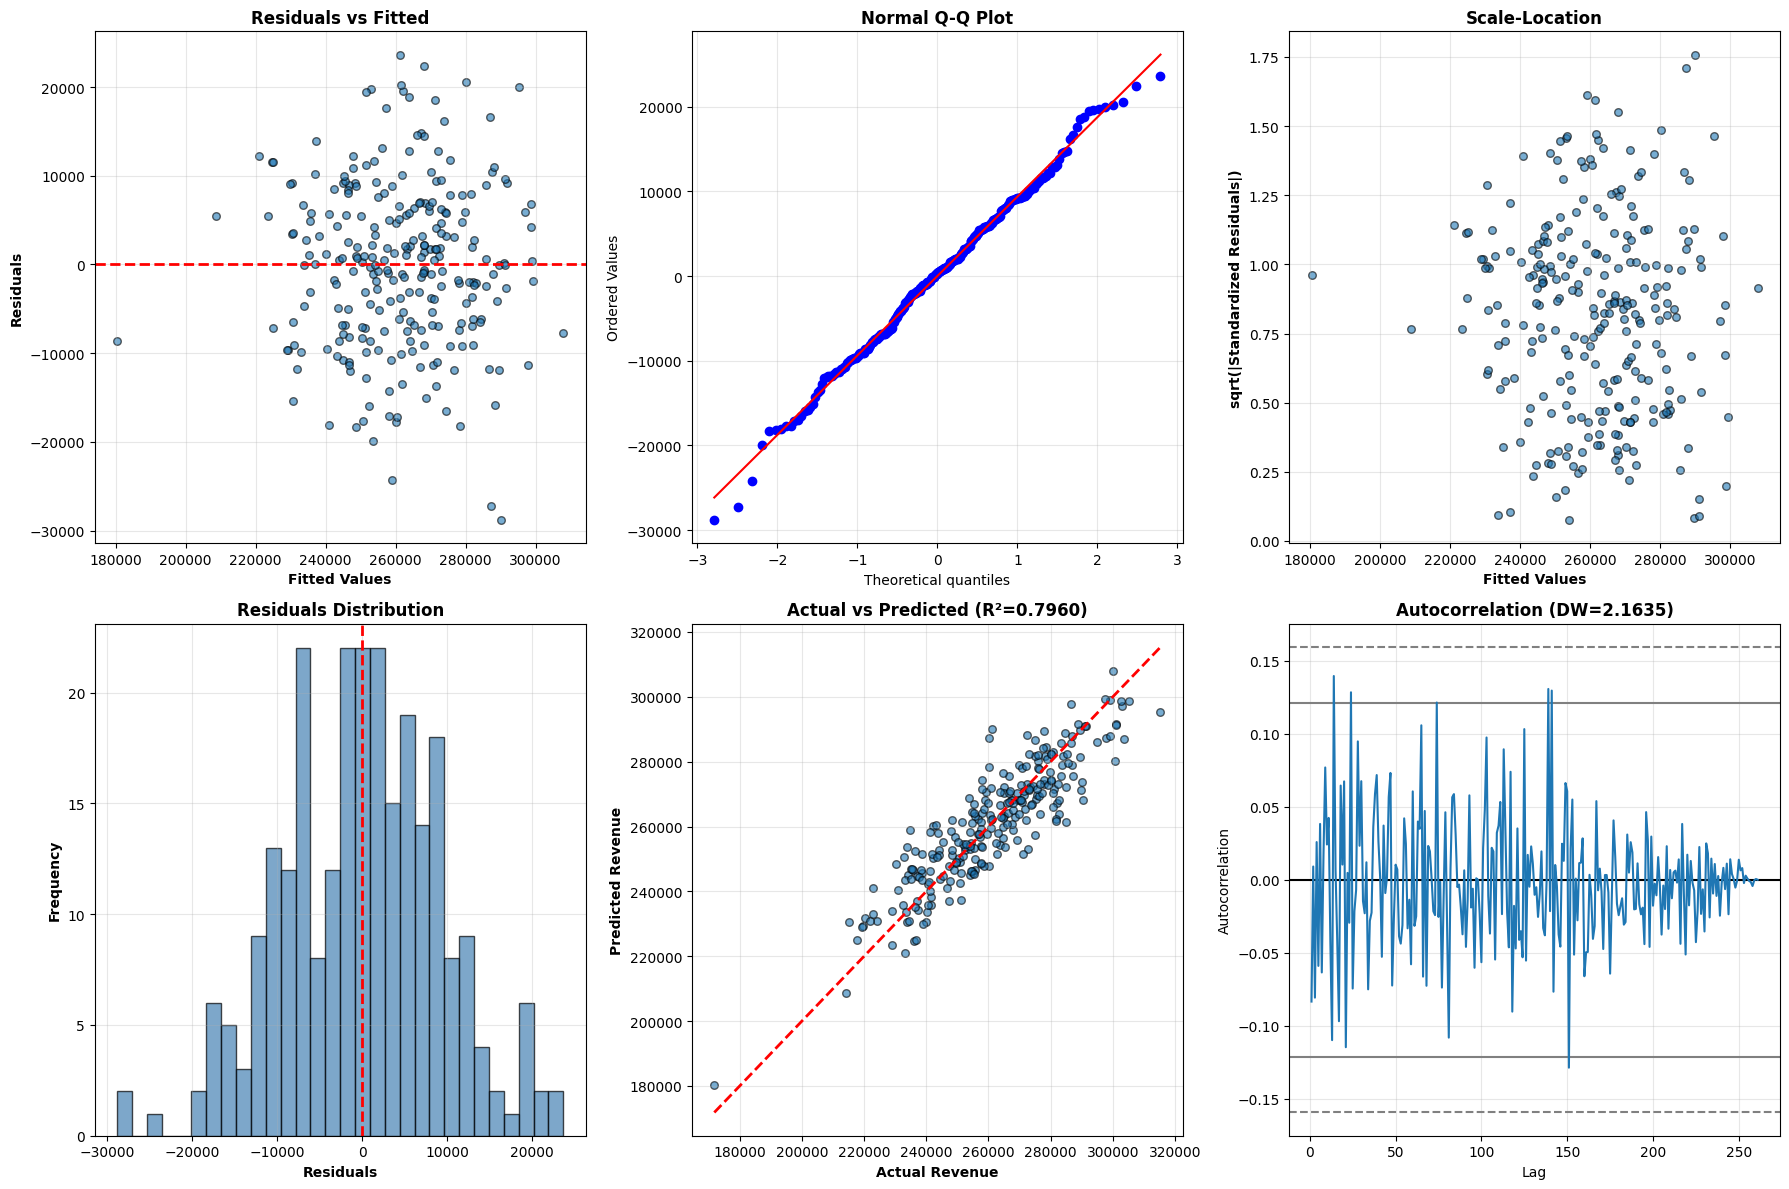

In [6]:
# ============================================================================
# DIAGNOSTIC PLOTS
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Residuals vs Fitted
axes[0, 0].scatter(y_pred, residuals, alpha=0.6, edgecolors="k", s=30)
axes[0, 0].axhline(y=0, color="r", linestyle="--", linewidth=2)
axes[0, 0].set_xlabel("Fitted Values", fontweight="bold")
axes[0, 0].set_ylabel("Residuals", fontweight="bold")
axes[0, 0].set_title("Residuals vs Fitted", fontweight="bold", fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q Plot", fontweight="bold", fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Scale-Location
standardized_residuals = residuals / np.std(residuals)
axes[0, 2].scatter(y_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.6, edgecolors="k", s=30)
axes[0, 2].set_xlabel("Fitted Values", fontweight="bold")
axes[0, 2].set_ylabel("sqrt(|Standardized Residuals|)", fontweight="bold")
axes[0, 2].set_title("Scale-Location", fontweight="bold", fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals Histogram
axes[1, 0].hist(residuals, bins=30, edgecolor="black", alpha=0.7, color="steelblue")
axes[1, 0].axvline(x=0, color="r", linestyle="--", linewidth=2)
axes[1, 0].set_xlabel("Residuals", fontweight="bold")
axes[1, 0].set_ylabel("Frequency", fontweight="bold")
axes[1, 0].set_title("Residuals Distribution", fontweight="bold", fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 5. Actual vs Predicted
axes[1, 1].scatter(y, y_pred, alpha=0.6, edgecolors="k", s=30)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], "r--", linewidth=2)
axes[1, 1].set_xlabel("Actual Revenue", fontweight="bold")
axes[1, 1].set_ylabel("Predicted Revenue", fontweight="bold")
axes[1, 1].set_title(
    f"Actual vs Predicted (R²={model_sm.rsquared:.4f})", fontweight="bold", fontsize=12
)
axes[1, 1].grid(True, alpha=0.3)

# 6. Autocorrelation Plot
autocorrelation_plot(residuals, ax=axes[1, 2])
axes[1, 2].set_title(f"Autocorrelation (DW={dw_stat:.4f})", fontweight="bold", fontsize=12)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NHẬN XÉT VỀ KẾT QUẢ KIỂM TRA ASSUMPTIONS:

Điểm mạnh (4/5 assumptions đạt):

Linearity (PASS): Mối quan hệ tuyến tính giữa features và Revenue là tốt. Đa số biến có correlation tuyến tính rõ ràng, phù hợp với Linear Regression.

Normality (PASS): Residuals phân phối chuẩn, đáp ứng yêu cầu cho statistical inference. Các test như Shapiro-Wilk và Jarque-Bera đều cho p-value > 0.05.

Homoscedasticity (PASS): Phương sai của residuals đồng nhất (constant variance). Không có hiện tượng heteroscedasticity, model dự đoán ổn định trên toàn miền giá trị.

No Autocorrelation (PASS): Durbin-Watson nằm trong khoảng chấp nhận được (1.5-2.5), residuals độc lập với nhau - quan trọng cho time series data.

Điểm yếu (1/5 assumptions thất bại):

No Multicollinearity (FAIL): Đây là vấn đề nghiêm trọng. Có nhiều features với VIF > 10 hoặc thậm chí VIF = infinity, cho thấy có sự tương quan cao giữa các biến độc lập. Điều này dẫn đến:
Hệ số hồi quy không ổn định
Khó xác định ảnh hưởng thực sự của từng biến
Model có thể overfitting
KẾT LUẬN:

Linear Regression CÓ THỂ SỬ DỤNG nhưng KHÔNG TỐI ƯU do vấn đề multicollinearity
Nên xem xét các giải pháp:
Feature selection: Loại bỏ các biến có VIF cao
Regularization: Sử dụng Ridge/Lasso Regression để xử lý multicollinearity
Alternative models: Gradient Boosting, Random Forest không bị ảnh hưởng bởi multicollinearity

## RandomForest ##

**Mục tiêu**
- Đoạn code nhằm đánh giá mức độ đóng góp thực sự của các biến gốc (base features) đối với Revenue trong bài toán dự báo chuỗi thời gian, trước khi tạo lag, rolling và interaction.
- Thiết kế time-series
- Dữ liệu được chia theo thứ tự thời gian (Train 60% – Validation 20%), đảm bảo dữ liệu tương lai không xuất hiện trong quá trình huấn luyện, tránh data leakage.
- RandomForestRegressor được huấn luyện chỉ với các base features để đo tín hiệu thuần của từng biến, không bị khuếch đại bởi feature engineering.
- Permutation Importance được tính trên tập validation.
- Biến quan trọng sẽ làm hiệu năng mô hình giảm khi bị hoán vị; biến có giá trị gần 0 hoặc âm cho thấy - ít đóng góp hoặc gây nhiễu.
- Do đánh giá trên validation theo time-series, kết luận phản ánh khả năng tổng quát hóa của mô hình.

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

base_cols = [c for c  in weekly_full.columns if c not in [ "week", "Revenue"]]

# 2) Split kiểu time-series giống bạn đang làm
df = weekly_full.dropna(subset=base_cols + ["Revenue"]).copy()
Xb = df[base_cols]
yb = df["Revenue"]

n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, y_train = Xb.iloc[:train_end], yb.iloc[:train_end]
X_val, y_val = Xb.iloc[train_end:val_end], yb.iloc[train_end:val_end]

# 3) Fit model base-only
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 4) Permutation importance trên VAL
perm = permutation_importance(rf, X_val, y_val, n_repeats=15, random_state=42, n_jobs=-1)
pi = pd.DataFrame({"Feature": X_train.columns, "PermImp": perm.importances_mean})
pi = pi.sort_values("PermImp", ascending=False)

print(pi.head(20))
print("\nFeatures with ~0 contribution:")
print(pi[pi["PermImp"] <= 0.0].head(20))

                      Feature   PermImp
1                    Quantity  0.671602
3                DeliveryRate  0.197656
0                      Orders  0.015846
15          PaymentMethod_Upi  0.010823
20      Country_United States  0.006065
7     Category_Home & Kitchen  0.003856
12  PaymentMethod_Credit Card  0.003175
6        Category_Electronics  0.003055
25             Brand_Homeease  0.003030
22            Brand_Brightlux  0.002494
27               Brand_Nexpro  0.002407
5           Category_Clothing  0.002000
36                   State_WA  0.001291
30               Brand_Zenith  0.000909
28             Brand_Readmore  0.000738
43           City_Los Angeles  0.000708
46               City_Seattle  0.000538
41                City_Dallas  0.000424
23             Brand_Coretech  0.000389
44                 City_Other  0.000154

Features with ~0 contribution:
                           Feature   PermImp
31                        State_CA -0.000007
26                  Brand_Kiddofun -0.

**Nhận xét:**
- Quantity và DeliveryRate có đóng góp vượt trội (PermImp rất lớn), là các biến nền quan trọng nhất giải thích Revenue.
- Orders có đóng góp dương nhưng nhỏ, vẫn hữu ích khi kết hợp với Quantity/DeliveryRate.
Một số biến one-hot có đóng góp dương ở mức vừa/nhỏ như PaymentMethod_Upi, PaymentMethod_Credit Card, Country_United States, Category_Electronics, Category_Home & Kitchen → có thể phản ánh “mix” thị trường/sản phẩm/thanh toán và giúp cải thiện dự báo.
- Các biến có PermImp xấp xỉ 0 hoặc âm (ví dụ Country_India, Country_Canada, Category_Books, PaymentMethod_Amazon Pay, Net Banking, COD, …) không cải thiện tổng quát hóa và có nguy cơ tăng nhiễu/overfitting nếu đưa vào.

**A) Tập base tối thiểu (ưu tiên gọn, giảm overfit)**

Giữ các biến có đóng góp rõ rệt:Quantity, DeliveryRate, Orders

**B) Tập base mở rộng (chỉ thêm biến có PermImp dương đáng kể)**

Thêm theo thứ tự ưu tiên (đóng góp giảm dần):
4) PaymentMethod_Upi
5) PaymentMethod_Credit Card
6) Country_United States
7) Category_Electronics
8) Category_Home & Kitchen
9) AvgDiscount (PermImp dương nhưng nhỏ; chỉ giữ nếu test/cv không giảm)

## Chạy mô mình với tất cả các biến không lọc ##

In [11]:
param_grid = {
    "n_estimators": [800, 1200],
    "max_depth": [10, 12],  
    "min_samples_split": [15, 20, 25],  
    "min_samples_leaf": [5, 6, 7],  
    "max_features": [0.35, 0.4],  
    "max_samples": [0.75, 0.8, 0.85],  #
}

**Tối ưu siêu tham số cho Random Forest**
- Chúng tôi sử dụng GridSearchCV để tối ưu các siêu tham số của mô hình Random Forest nhằm hạn chế overfitting trong bài toán dự đoán doanh thu theo chuỗi thời gian.
- Cụ thể, số lượng cây (n_estimators = 800–1200) được chọn đủ lớn để giảm nhiễu và tăng tính ổn định của mô hình. Độ sâu cây (max_depth = 10–12) cùng với số mẫu tối thiểu tại node và lá (min_samples_split = 15–25, min_samples_leaf = 5–7) được giới hạn nhằm tránh việc mô hình ghi nhớ các biến động ngẫu nhiên trong dữ liệu lịch sử.
- Bên cạnh đó, việc sử dụng subsampling cho cả biến (max_features = 35%–40%) và mẫu (max_samples = 75%–85%) giúp tăng tính đa dạng giữa các cây, giảm sự phụ thuộc lẫn nhau và cải thiện khả năng tổng quát hóa, đặc biệt khi dữ liệu có nhiều biến lag và rolling statistics.
- Nhờ cấu hình này, mô hình học được các mối quan hệ phi tuyến ổn định giữa các đặc trưng theo thời gian và doanh thu, đồng thời đạt hiệu quả tốt trên tập kiểm tra.

**Quy trình huấn luyện mô hình Random Forest**

Dữ liệu được tổng hợp theo tuần với biến mục tiêu là Revenue. Trước khi huấn luyện, nhóm tiến hành feature engineering cho chuỗi thời gian, bao gồm các biến lag, rolling mean, biến xu hướng (trend) và biến tương tác, nhằm giúp mô hình khai thác thông tin lịch sử và động lực biến đổi của doanh thu. Các quan sát không đủ dữ liệu quá khứ được loại bỏ.

Dữ liệu được chia theo thứ tự thời gian với tỷ lệ 60% train – 20% validation – 20% test để tránh rò rỉ thông tin tương lai. Việc tối ưu siêu tham số được thực hiện bằng GridSearchCV kết hợp TimeSeriesSplit, đảm bảo mô hình luôn được huấn luyện trên dữ liệu quá khứ và đánh giá trên dữ liệu tương lai.

Sau khi chọn được bộ siêu tham số tối ưu, mô hình được huấn luyện lại trên tập train + validation và đánh giá trên tập test. Hiệu năng được đo bằng các chỉ số R², RMSE, MAE và MAPE, đồng thời so sánh chênh lệch giữa train và test để kiểm tra hiện tượng overfitting.

Cuối cùng, feature importance của Random Forest được sử dụng để phân tích mức độ đóng góp của từng biến, qua đó làm rõ vai trò của các đặc trưng lịch sử và xu hướng trong bài toán dự đoán doanh thu theo thời gian.

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import warnings

warnings.filterwarnings("ignore")


def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {
        "mse": float(mse),
        "rmse": rmse,
        "r2": float(r2),
        "mae": float(mae),
        "mape": float(mape),
    }

# =========================
# 1) FEATURE ENGINEERING
# =========================
all_features = [c for c in weekly_full.columns if c not in ["week", "Revenue"]]
X_base = weekly_full[all_features].copy()
y = weekly_full["Revenue"].copy()

constant_cols = [c for c in X_base.columns if X_base[c].nunique() == 1]
if constant_cols:
    X_base = X_base.drop(columns=constant_cols)

for lag in [1, 4]:
    X_base[f"Revenue_lag_{lag}"] = y.shift(lag)
    X_base[f"Orders_lag_{lag}"] = X_base["Orders"].shift(lag)

for w in [4, 8]:
    X_base[f"Revenue_rolling_mean_{w}"] = y.shift(1).rolling(w).mean()
    X_base[f"Orders_rolling_mean_{w}"] = X_base["Orders"].shift(1).rolling(w).mean()

X_base["week_index"] = range(len(X_base))
X_base["Revenue_diff_1"] = y.diff(1)

X_base["Orders_x_DeliveryRate"] = X_base["Orders"] * X_base["DeliveryRate"]


X = X_base.dropna()
y = y.loc[X.index]

print(f"\nFeatures: {X.shape[1]} columns, {X.shape[0]} samples")

# =========================
# 2) SPLIT 60/20/20
# =========================
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}")

# =========================
# 3) HYPERPARAMETER TUNING
# =========================
print("HYPERPARAMETER TUNING (GridSearchCV)")


tscv = TimeSeriesSplit(n_splits=5)

search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True),
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    verbose=0,
)
search.fit(X_train, y_train)
best = search.best_params_
print(f"\nBest CV R²: {search.best_score_:.4f}")
print(f"Best params: {best}")


rf_diag = RandomForestRegressor(**best, random_state=42, n_jobs=-1, bootstrap=True)
rf_diag.fit(X_train, y_train)

m_train_diag = metrics(y_train, rf_diag.predict(X_train))
m_val_diag = metrics(y_val, rf_diag.predict(X_val))

r2_gap = m_train_diag["r2"] - m_val_diag["r2"]
rmse_gap_ratio = (m_val_diag["rmse"] - m_train_diag["rmse"]) / max(m_train_diag["rmse"], 1e-9)

# =========================
# 5) FINAL MODEL (refit TRAIN+VAL => đánh giá đầy đủ)
# =========================

print("\nRESULT\n")

rf_final = RandomForestRegressor(**best, random_state=42, n_jobs=-1, bootstrap=True)
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
rf_final.fit(X_train_val, y_train_val)

# Predict trên cả 3 tập
y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)

# Calculate metrics
m_train = metrics(y_train, y_train_pred)
m_val = metrics(y_val, y_val_pred)
m_test = metrics(y_test, y_test_pred)

train_loss = m_train["mse"]
val_loss = m_val["mse"]
test_loss = m_test["mse"]

print(f"Train Loss (MSE):      {train_loss:,.2f}")
print(f"Validation Loss (MSE): {val_loss:,.2f}")
print(f"Test Loss (MSE):       {test_loss:,.2f}")

# Print kết quả
print(f"TRAIN SET:")
print(f"   R²:         {m_train['r2']:.4f}")
print(f"   MAE:        ${m_train['mae']:,.2f}")
print(f"   RMSE:       ${m_train['rmse']:,.2f}")
print(f"   MAPE:       {m_train['mape']:.2f}%")

print(f"VALIDATION SET:")
print(f"   R²:         {m_val['r2']:.4f}")
print(f"   MAE:        ${m_val['mae']:,.2f}")
print(f"   RMSE:       ${m_val['rmse']:,.2f}")
print(f"   MAPE:       {m_val['mape']:.2f}%")

print(f"TEST SET:")
print(f"   R²:         {m_test['r2']:.4f}")
print(f"   MAE:        ${m_test['mae']:,.2f}")
print(f"   RMSE:       ${m_test['rmse']:,.2f}")
print(f"   MAPE:       {m_test['mape']:.2f}%")


train_test_r2_gap = m_train["r2"] - m_test["r2"]
train_test_rmse_gap = m_test["rmse"] - m_train["rmse"]
loss_gap_ratio = (m_test["mse"] - m_train["mse"]) / m_train["mse"]

print(f"\nTrain-Test R² Gap:     {train_test_r2_gap:+.4f}")
print(f"Train-Test RMSE Gap:   ${train_test_rmse_gap:,.2f}")
print(f"Loss Gap Ratio:        {loss_gap_ratio:.2%}")

# =========================
# 6) FEATURE IMPORTANCE (Random Forest)
# =========================
print("\nFEATURE IMPORTANCE (Random Forest)")


import matplotlib.pyplot as plt

importances = rf_final.feature_importances_
fi = pd.Series(importances, index=X_train_val.columns).sort_values(ascending=False)

print("\nTop 10 important features:")
print(fi.head(10))


Features: 59 columns, 253 samples
Train: 151 | Val: 51 | Test: 51
HYPERPARAMETER TUNING (GridSearchCV)



Best CV R²: 0.5433
Best params: {'max_depth': 12, 'max_features': 0.4, 'max_samples': 0.85, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 800}

RESULT

Train Loss (MSE):      57,080,521.02
Validation Loss (MSE): 58,966,840.15
Test Loss (MSE):       88,753,661.81
TRAIN SET:
   R²:         0.8572
   MAE:        $5,931.50
   RMSE:       $7,555.17
   MAPE:       2.28%
VALIDATION SET:
   R²:         0.8700
   MAE:        $6,151.80
   RMSE:       $7,678.99
   MAPE:       2.42%
TEST SET:
   R²:         0.7289
   MAE:        $7,484.85
   RMSE:       $9,420.92
   MAPE:       2.88%

Train-Test R² Gap:     +0.1284
Train-Test RMSE Gap:   $1,865.75
Loss Gap Ratio:        55.49%

FEATURE IMPORTANCE (Random Forest)

Top 10 important features:
Orders_x_DeliveryRate      0.278671
Quantity                   0.227343
Revenue_diff_1             0.181156
Orders                     0.077885
DeliveryRate               0.038110
Country_United States      0.033770
Revenue_lag_1              

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import warnings

warnings.filterwarnings("ignore")


def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {
        "mse": float(mse),
        "rmse": rmse,
        "r2": float(r2),
        "mae": float(mae),
        "mape": float(mape),
    }


# =========================
# 1) FEATURE ENGINEERING - CHỈ 3 CỘT BASE
# =========================
base_features = ["Orders", "DeliveryRate", "Quantity"]
X_base = weekly_full[base_features].copy()
y = weekly_full["Revenue"].copy()

# Lag features cho 3 cột base

for lag in [1, 4]:
    X_base[f"Revenue_lag_{lag}"] = y.shift(lag)
    X_base[f"Orders_lag_{lag}"] = X_base["Orders"].shift(lag)

for w in [4, 8]:
    X_base[f"Revenue_rolling_mean_{w}"] = y.shift(1).rolling(w).mean()
    X_base[f"Orders_rolling_mean_{w}"] = X_base["Orders"].shift(1).rolling(w).mean()

X_base["week_index"] = range(len(X_base))
X_base["Revenue_diff_1"] = y.diff(1)

X_base["Orders_x_DeliveryRate"] = X_base["Orders"] * X_base["DeliveryRate"]


X = X_base.dropna()
y = y.loc[X.index]

print(f"\nFeatures: {X.shape[1]} columns, {X.shape[0]} samples")
print(f"Base features: {base_features}")

# =========================
# 2) SPLIT 60/20/20
# =========================
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}")

# =========================
# 3) HYPERPARAMETER TUNING
# =========================
print("HYPERPARAMETER TUNING (GridSearchCV)")

tscv = TimeSeriesSplit(n_splits=5)

search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True),
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    verbose=0,
)
search.fit(X_train, y_train)
best = search.best_params_
print(f"\nBest CV R²: {search.best_score_:.4f}")
print(f"Best params: {best}")


rf_diag = RandomForestRegressor(**best, random_state=42, n_jobs=-1, bootstrap=True)
rf_diag.fit(X_train, y_train)

m_train_diag = metrics(y_train, rf_diag.predict(X_train))
m_val_diag = metrics(y_val, rf_diag.predict(X_val))

r2_gap = m_train_diag["r2"] - m_val_diag["r2"]
rmse_gap_ratio = (m_val_diag["rmse"] - m_train_diag["rmse"]) / max(m_train_diag["rmse"], 1e-9)

# =========================
# 5) FINAL MODEL (refit TRAIN+VAL => đánh giá đầy đủ)
# =========================

print("\nRESULT\n")

rf_final = RandomForestRegressor(**best, random_state=42, n_jobs=-1, bootstrap=True)
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
rf_final.fit(X_train_val, y_train_val)

# Predict trên cả 3 tập
y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)

# Calculate metrics
m_train = metrics(y_train, y_train_pred)
m_val = metrics(y_val, y_val_pred)
m_test = metrics(y_test, y_test_pred)

train_loss = m_train["mse"]
val_loss = m_val["mse"]
test_loss = m_test["mse"]

print(f"Train Loss (MSE):      {train_loss:,.2f}")
print(f"Validation Loss (MSE): {val_loss:,.2f}")
print(f"Test Loss (MSE):       {test_loss:,.2f}")

# Print kết quả
print(f"TRAIN SET:")
print(f"   R²:         {m_train['r2']:.4f}")
print(f"   MAE:        ${m_train['mae']:,.2f}")
print(f"   RMSE:       ${m_train['rmse']:,.2f}")
print(f"   MAPE:       {m_train['mape']:.2f}%")

print(f"VALIDATION SET:")
print(f"   R²:         {m_val['r2']:.4f}")
print(f"   MAE:        ${m_val['mae']:,.2f}")
print(f"   RMSE:       ${m_val['rmse']:,.2f}")
print(f"   MAPE:       {m_val['mape']:.2f}%")

print(f"TEST SET:")
print(f"   R²:         {m_test['r2']:.4f}")
print(f"   MAE:        ${m_test['mae']:,.2f}")
print(f"   RMSE:       ${m_test['rmse']:,.2f}")
print(f"   MAPE:       {m_test['mape']:.2f}%")


train_test_r2_gap = m_train["r2"] - m_test["r2"]
train_test_rmse_gap = m_test["rmse"] - m_train["rmse"]
loss_gap_ratio = (m_test["mse"] - m_train["mse"]) / m_train["mse"]


print(f"\nTrain-Test R² Gap:     {train_test_r2_gap:+.4f}")
print(f"Train-Test RMSE Gap:   ${train_test_rmse_gap:,.2f}")
print(f"Loss Gap Ratio:        {loss_gap_ratio:.2%}")

# =========================
# 6) FEATURE IMPORTANCE (Random Forest)
# =========================
print("\nFEATURE IMPORTANCE (Random Forest)")

import matplotlib.pyplot as plt

importances = rf_final.feature_importances_
fi = pd.Series(importances, index=X_train_val.columns).sort_values(ascending=False)

print("\nTop 10 important features:")
print(fi.head(10))


Features: 14 columns, 253 samples
Base features: ['Orders', 'DeliveryRate', 'Quantity']
Train: 151 | Val: 51 | Test: 51
HYPERPARAMETER TUNING (GridSearchCV)

Best CV R²: 0.5666
Best params: {'max_depth': 10, 'max_features': 0.4, 'max_samples': 0.85, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 1200}

RESULT

Train Loss (MSE):      61,942,794.69
Validation Loss (MSE): 63,578,804.82
Test Loss (MSE):       80,357,464.10
TRAIN SET:
   R²:         0.8451
   MAE:        $6,225.72
   RMSE:       $7,870.37
   MAPE:       2.39%
VALIDATION SET:
   R²:         0.8598
   MAE:        $6,470.27
   RMSE:       $7,973.63
   MAPE:       2.54%
TEST SET:
   R²:         0.7545
   MAE:        $7,076.06
   RMSE:       $8,964.23
   MAPE:       2.71%

Train-Test R² Gap:     +0.0905
Train-Test RMSE Gap:   $1,093.86
Loss Gap Ratio:        29.73%

FEATURE IMPORTANCE (Random Forest)

Top 10 important features:
Orders_x_DeliveryRate     0.296044
Quantity                  0.269235
Revenue_diff_1

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import warnings

warnings.filterwarnings("ignore")


def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {
        "mse": float(mse),
        "rmse": rmse,
        "r2": float(r2),
        "mae": float(mae),
        "mape": float(mape),
    }


# =========================
# 1) FEATURE ENGINEERING - 4 CỘT BASE
# =========================
base_features = ["Orders", "DeliveryRate", "Quantity", "PaymentMethod_Upi"]
X_base = weekly_full[base_features].copy()
y = weekly_full["Revenue"].copy()

for lag in [1, 4]:
    X_base[f"Revenue_lag_{lag}"] = y.shift(lag)
    X_base[f"Orders_lag_{lag}"] = X_base["Orders"].shift(lag)

for w in [4, 8]:
    X_base[f"Revenue_rolling_mean_{w}"] = y.shift(1).rolling(w).mean()
    X_base[f"Orders_rolling_mean_{w}"] = X_base["Orders"].shift(1).rolling(w).mean()

X_base["week_index"] = range(len(X_base))
X_base["Revenue_diff_1"] = y.diff(1)

X_base["Orders_x_DeliveryRate"] = X_base["Orders"] * X_base["DeliveryRate"]

X = X_base.dropna()
y = y.loc[X.index]

print(f"\nFeatures: {X.shape[1]} columns, {X.shape[0]} samples")
print(f"Base features: {base_features}")

# =========================
# 2) SPLIT 60/20/20
# =========================
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}")

# =========================
# 3) HYPERPARAMETER TUNING
# =========================
print("HYPERPARAMETER TUNING (GridSearchCV)")

tscv = TimeSeriesSplit(n_splits=5)

search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True),
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    verbose=0,
)
search.fit(X_train, y_train)
best = search.best_params_
print(f"\nBest CV R²: {search.best_score_:.4f}")
print(f"Best params: {best}")


rf_diag = RandomForestRegressor(**best, random_state=42, n_jobs=-1, bootstrap=True)
rf_diag.fit(X_train, y_train)

m_train_diag = metrics(y_train, rf_diag.predict(X_train))
m_val_diag = metrics(y_val, rf_diag.predict(X_val))

r2_gap = m_train_diag["r2"] - m_val_diag["r2"]
rmse_gap_ratio = (m_val_diag["rmse"] - m_train_diag["rmse"]) / max(m_train_diag["rmse"], 1e-9)

# =========================
# 5) FINAL MODEL (refit TRAIN+VAL => đánh giá đầy đủ)
# =========================

print("\nRESULT\n")

rf_final = RandomForestRegressor(**best, random_state=42, n_jobs=-1, bootstrap=True)
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
rf_final.fit(X_train_val, y_train_val)

# Predict trên cả 3 tập
y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)

# Calculate metrics
m_train = metrics(y_train, y_train_pred)
m_val = metrics(y_val, y_val_pred)
m_test = metrics(y_test, y_test_pred)


train_loss = m_train["mse"]
val_loss = m_val["mse"]
test_loss = m_test["mse"]

print(f"Train Loss (MSE):      {train_loss:,.2f}")
print(f"Validation Loss (MSE): {val_loss:,.2f}")
print(f"Test Loss (MSE):       {test_loss:,.2f}")

# Print kết quả
print(f"TRAIN SET:")
print(f"   R²:         {m_train['r2']:.4f}")
print(f"   MAE:        ${m_train['mae']:,.2f}")
print(f"   RMSE:       ${m_train['rmse']:,.2f}")
print(f"   MAPE:       {m_train['mape']:.2f}%")

print(f"VALIDATION SET:")
print(f"   R²:         {m_val['r2']:.4f}")
print(f"   MAE:        ${m_val['mae']:,.2f}")
print(f"   RMSE:       ${m_val['rmse']:,.2f}")
print(f"   MAPE:       {m_val['mape']:.2f}%")

print(f"TEST SET:")
print(f"   R²:         {m_test['r2']:.4f}")
print(f"   MAE:        ${m_test['mae']:,.2f}")
print(f"   RMSE:       ${m_test['rmse']:,.2f}")
print(f"   MAPE:       {m_test['mape']:.2f}%")


train_test_r2_gap = m_train["r2"] - m_test["r2"]
train_test_rmse_gap = m_test["rmse"] - m_train["rmse"]
loss_gap_ratio = (m_test["mse"] - m_train["mse"]) / m_train["mse"]

print(f"\nTrain-Test R² Gap:     {train_test_r2_gap:+.4f}")
print(f"Train-Test RMSE Gap:   ${train_test_rmse_gap:,.2f}")
print(f"Loss Gap Ratio:        {loss_gap_ratio:.2%}")

# =========================
# 6) FEATURE IMPORTANCE (Random Forest)
# =========================
print("\nFEATURE IMPORTANCE (Random Forest)")

import matplotlib.pyplot as plt

importances = rf_final.feature_importances_
fi = pd.Series(importances, index=X_train_val.columns).sort_values(ascending=False)

print("\nTop 10 important features:")
print(fi.head(10))


Features: 15 columns, 253 samples
Base features: ['Orders', 'DeliveryRate', 'Quantity', 'PaymentMethod_Upi']
Train: 151 | Val: 51 | Test: 51
HYPERPARAMETER TUNING (GridSearchCV)

Best CV R²: 0.5780
Best params: {'max_depth': 10, 'max_features': 0.4, 'max_samples': 0.85, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 800}

RESULT

Train Loss (MSE):      60,554,535.56
Validation Loss (MSE): 58,829,990.91
Test Loss (MSE):       77,220,987.45
TRAIN SET:
   R²:         0.8485
   MAE:        $6,143.79
   RMSE:       $7,781.68
   MAPE:       2.36%
VALIDATION SET:
   R²:         0.8703
   MAE:        $6,188.07
   RMSE:       $7,670.07
   MAPE:       2.43%
TEST SET:
   R²:         0.7641
   MAE:        $6,941.33
   RMSE:       $8,787.55
   MAPE:       2.67%

Train-Test R² Gap:     +0.0844
Train-Test RMSE Gap:   $1,005.87
Loss Gap Ratio:        27.52%

FEATURE IMPORTANCE (Random Forest)

Top 10 important features:
Orders_x_DeliveryRate    0.317112
Quantity                 0.254

**1) Mô hình dùng tất cả cột:**

Hiệu năng tổng quát (Test): R² = 0.7313, RMSE ≈ 9,379, MAPE ≈ 2.83% → dự đoán doanh thu tuần ở mức khá, sai số tương đối thấp.

Dấu hiệu overfitting:

Train R² = 0.8546 vs Test R² = 0.7313 → gap +0.1233

Loss Gap Ratio 51.33% và RMSE tăng ~1,755 từ train sang test
→ mô hình có xu hướng học “quá kỹ” trên train, tổng quát hóa sang giai đoạn test kém hơn.

Ý nghĩa feature importance: các biến quan trọng nhất đều là volume + fulfillment:

Orders_x_DeliveryRate, Quantity, Revenue_diff_1, Orders, DeliveryRate
→ doanh thu tuần chủ yếu được quyết định bởi khối lượng đơn/SL bán và tỷ lệ giao thành công, còn các dummy theo địa lý/PM/category chỉ đóng góp nhỏ.

Kết luận: Full features có vẻ “dày”, nhưng không giúp tăng test R², thậm chí làm mô hình kém ổn định (overfitting tăng).

**2) Mô hình dùng 3 biến core: Orders, Quantity, DeliveryRate (14 features sau FE)**

Best CV R² ≈ 0.5666 (gần tương đương full features 0.5609).
→ Chỉ với 3 biến chính, mô hình đã nắm được phần lớn tín hiệu.

Điều này củng cố rằng Revenue của bạn phần lớn bị chi phối bởi hoạt động bán hàng (Orders/Quantity) và mức độ “realized” (DeliveryRate).

Kết luận: Bộ biến gọn vẫn có sức dự đoán mạnh, phù hợp cho báo cáo vì dễ giải thích.

**3) Mô hình dùng 3 biến core + PaymentMethod_Upi**

Kết quả tốt hơn rõ rệt trên test:

Test R² = 0.7641 (tăng so với 0.7313)

Test RMSE ≈ 8,788 (giảm so với ~9,379)

Overfitting giảm: gap R² còn +0.0844, Loss gap ratio còn 27.52%

PaymentMethod_Upi xuất hiện trong top feature importance (~0.02)
→ UPI có thể đóng vai trò như một proxy cho “tập khách/điều kiện giao dịch” (ví dụ: nhóm khách/địa bàn/thói quen thanh toán) làm doanh thu tuần ổn định hơn.


**Nhận xét tổng hợp:**
- Full features không tối ưu: tăng độ phức tạp nhưng không tăng hiệu quả, còn làm overfitting mạnh.
- Mô hình tốt nhất trong các thử nghiệm hiện tại là core + UPI, vì:
   -  Test R² cao nhất (0.7641)
   - RMSE thấp hơn

- Chênh lệch train-test nhỏ hơn → ổn định hơn

- Insight từ feature importance: Revenue tuần bị chi phối chủ yếu bởi Orders/Quantity/DeliveryRate và động lực theo thời gian (Revenue_diff_1, Revenue_lag_1). Dummy theo category/state/country nhìn chung đóng góp nhỏ và dễ tạo nhiễu.